# Instance Segmentation and Metric Measurement Pipeline

This notebook presents a generic instance segmentation and photogrammetry-based
measurement pipeline developed to estimate object dimensions from monocular images.
The focus is on camera calibration, distortion correction, and metric validation.

**Author:** Manuel Josue Malla Campoverde  

## Initial configuration

In [1]:
!nvidia-smi

import sys
print(f"Python version: {sys.version}")

!pip install ultralytics roboflow
!pip install supervision
!pip install rfdetr
!pip install -U ultralytics sahi

Fri Oct 24 03:24:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Photogrammetry

The photogrammetry workflow consists of three main stages:

**1. Camera Calibration**

Camera calibration is performed using Zhang’s method with multiple images of a planar
checkerboard pattern captured under different poses. Corner points are detected and
refined to subpixel accuracy. The intrinsic camera matrix K and distortion coefficients
are estimated.

Additionally, an average scale factor (mm/px) is computed from the known distances
between adjacent checkerboard corners.

Calibration quality is assessed using the reprojection RMS error, with values below
0.5 pixels considered acceptable.

**2. Distortion Correction (Undistort)**

The estimated calibration parameters are used to remove lens distortion from new images.
An optimal camera matrix is computed using getOptimalNewCameraMatrix with
alpha = 1 to preserve the full field of view.

Remapping matrices are generated and applied using bilinear interpolation. For geometric
consistency, detected keypoints are also corrected using undistortPoints.

**3. Metric Evaluation**

The metric accuracy of the system is validated using a planar object with known
dimensions. Pixel distances between corrected vertices are measured and converted to
millimeters using the local mm/px scale.

Errors are computed either per edge or by total area comparison. The Mean Absolute Error
(MAE) is reported, with an acceptance threshold of ≤ 0.5 mm.

This evaluation procedure follows principles similar to checkerboard-based calibration
validation.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from typing import Tuple, Optional

# ================== GLOBAL CONFIG ==================
UNITS = "mm"
SUBPIX_CRITERIA = (
    cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
    30,
    1e-3,
)

In [ ]:
def show_image_bgr(img: np.ndarray, title: Optional[str] = None, size: int = 8) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


def order_quad_points(points: np.ndarray) -> np.ndarray:
    pts = np.asarray(points, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    return np.array([tl, tr, br, bl], dtype=np.float32)


def calibrate_camera_from_checkerboard(
    images_glob: str,
    pattern_size: Tuple[int, int],
    square_size_mm: float,
    save_path: str = "camera_calibration.pkl",
    visualize: bool = False,
):
    """
    Perform camera calibration using a planar checkerboard pattern following Zhang's method.

    Parameters:
    - images_glob : str - Glob pattern to calibration images.
    - pattern_size : (int, int) - Number of inner corners (columns, rows).
    - square_size_mm : float - Physical size of one checkerboard square in millimeters.
    - save_path : str - Path to store calibration parameters.
    - visualize : bool - Whether to visualize detected corners.

    Returns:
    - K : np.ndarray - Camera intrinsic matrix.
    - dist : np.ndarray - Distortion coefficients.
    - rms : float - Reprojection RMS error in pixels.
    - mm_per_px : Optional[float] - Estimated average metric scale (mm/px).
    """

    image_paths = sorted(glob.glob(images_glob))
    if not image_paths:
        raise FileNotFoundError("No calibration images found.")

    cols, rows = pattern_size

    objp = np.zeros((rows * cols, 3), np.float32)
    objp[:, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2)
    objp *= square_size_mm

    object_points = []
    image_points = []
    image_shape = None

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image_shape = gray.shape[::-1]

        found, corners = cv2.findChessboardCorners(
            gray,
            (cols, rows),
            flags=cv2.CALIB_CB_ADAPTIVE_THRESH
            + cv2.CALIB_CB_NORMALIZE_IMAGE,
        )

        if not found:
            continue

        refined = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), SUBPIX_CRITERIA
        )

        object_points.append(objp)
        image_points.append(refined)

        if visualize:
            vis = img.copy()
            cv2.drawChessboardCorners(vis, (cols, rows), refined, True)
            show_image_bgr(vis, f"Esquinas detectadas: {os.path.basename(path)}", size=6)

    if not object_points:
        raise RuntimeError("Checkerboard corners were not detected in any image.")

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        object_points, image_points, image_shape, None, None
    )

    # Reprojection RMS Error
    total_error = 0.0
    total_points = 0

    for i in range(len(object_points)):
        projected, _ = cv2.projectPoints(
            object_points[i], rvecs[i], tvecs[i], K, dist
        )
        error = cv2.norm(image_points[i], projected, cv2.NORM_L2)
        total_error += error
        total_points += len(projected)

    rms = total_error / total_points

    # Metric Scale Estimation(mm/px)
    scales = []

    for pts in image_points:
        pts = pts.reshape(-1, 2)

        for i in range(cols - 1):
            d_px = np.linalg.norm(pts[i + 1] - pts[i])
            if d_px > 0:
                scales.append(square_size_mm / d_px)

        for i in range(0, cols * (rows - 1), cols):
            d_px = np.linalg.norm(pts[i + cols] - pts[i])
            if d_px > 0:
                scales.append(square_size_mm / d_px)

    mm_per_px = float(np.mean(scales)) if scales else None

    with open(save_path, "wb") as f:
        pickle.dump(
            {
                "K": K,
                "dist": dist,
                "pattern_size": pattern_size,
                "square_mm": square_size_mm,
                "rms_px": rms,
                "mm_per_px": mm_per_px,
            },
            f,
        )

    return K, dist, rms, mm_per_px


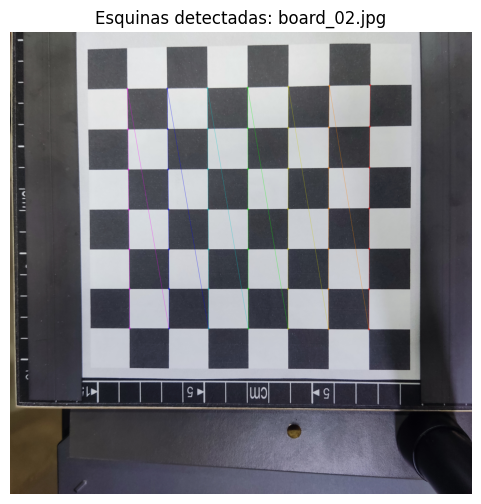

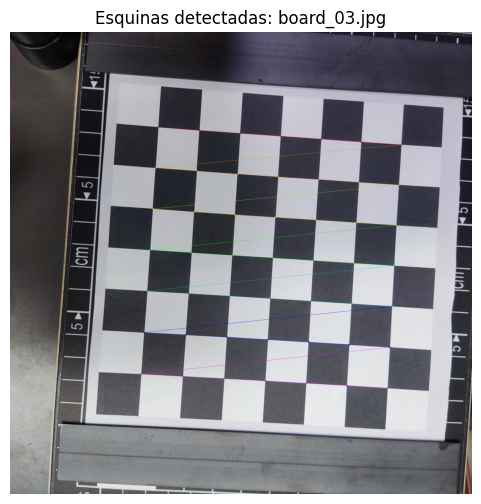

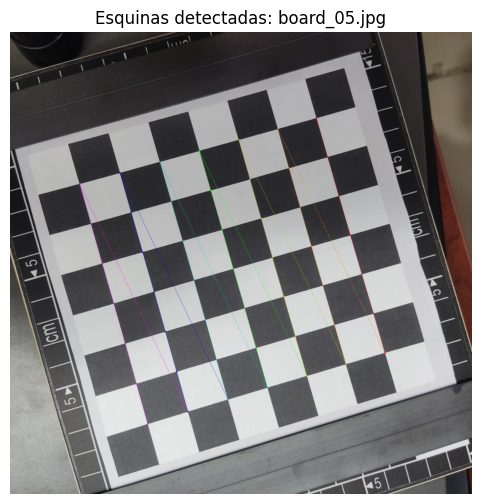

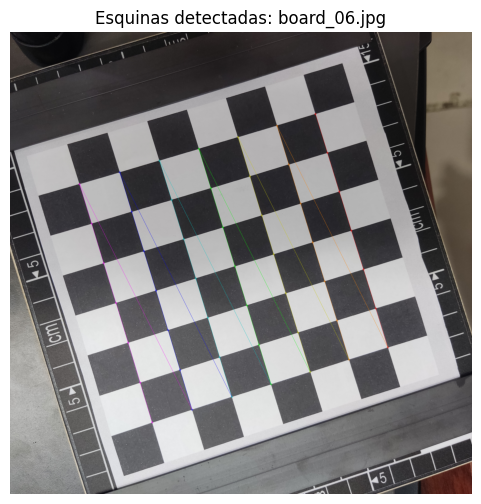

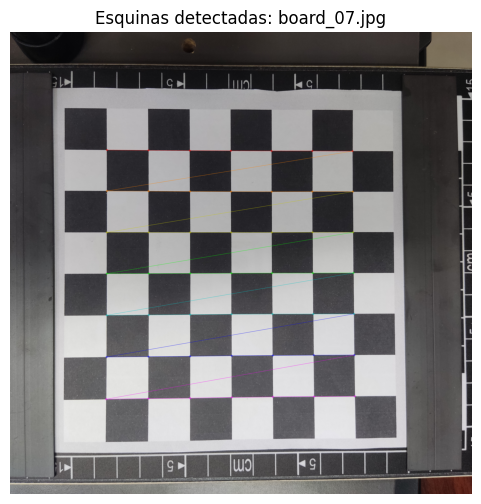

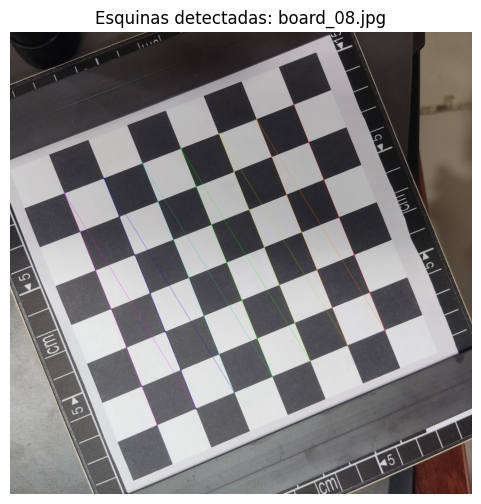


[INFO] Escala promedio estimada: 0.075385 mm/px
[OK] Calibración finalizada
K:
[[3.52000418e+03 0.00000000e+00 1.49312647e+03]
 [0.00000000e+00 3.52047661e+03 1.45385529e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist:
[[ 2.13442194e-01 -2.20016159e+00 -9.09113149e-04 -4.91779103e-04
   8.46278650e+00]]
RMS reproyección: 0.0960 px
mm/px: 0.075385 mm/px
Calibración guardada en calibration.pkl


In [ ]:
CALIB_GLOB = "..."
PATTERN    = (7,7)
SQUARE_MM  = 25.0 #Example square size in mm
save_pkl  = "calibration.pkl"

K, dist, rms, mm_per_px = calibrate_camera_from_checkerboard(
    images_glob=CALIB_GLOB,
    pattern_size=PATTERN,
    square_size_mm=SQUARE_MM,
    save_pkl=save_pkl,
    visualize=True
)

if mm_per_px:
    print(f"Estimated Metric Scale: {mm_per_px:.4f} {UNITS}/px")

print(f"[OK] Calibración finalizada")
print(f"K:\n{K}\ndist:\n{dist}")
print(f"RMS reproyección: {rms:.4f} px")
if mm_per_px is not None:
    print(f"mm/px: {mm_per_px:.6f} {UNITS}/px")

print(f"Calibración guardada en {save_pkl}")

In [ ]:
def apply_calibration_to_image(
    image_path: str,
    calibration_file: str,
    show: bool = True,
):
    """
    Apply camera calibration parameters to undistort a single image.

    Parameters: 
    - image_path : str - Path to input image.
    - calibration_file : str - Path to stored calibration parameters.
    - show : bool - Whether to display original vs undistorted image.

    Returns:
    corrected : np.ndarray - Undistorted image.
    """

    with open(calibration_file, "rb") as f:
        calib = pickle.load(f)

    K, dist = calib["K"], calib["dist"]

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)

    h, w = img.shape[:2]
    newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))
    mapx, mapy = cv2.initUndistortRectifyMap(
        K, dist, None, newK, (w, h), cv2.CV_32FC1
    )
    corrected = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    if show:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Original")
        ax[0].axis("off")

        ax[1].imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
        ax[1].set_title("Corregida (Undistorted)")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

    return corrected

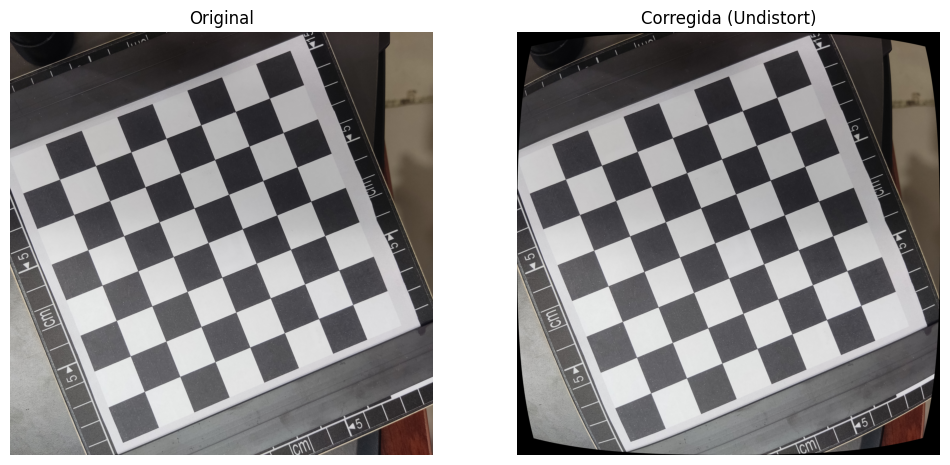

[OK] Imagen corregida guardada en: ./corrected/undistorted_board_08.jpg


In [ ]:
img_path = ".."
pkl_path = "calibration.pkl"

corrected = apply_calibration_to_image(
    image_path=img_path,
    calibration_file=pkl_path,
    show=True,
)

In [ ]:
def order_points_clockwise(pts):
    center = np.mean(pts, axis=0)
    angles = np.arctan2(pts[:,1] - center[1], pts[:,0] - center[0])
    return pts[np.argsort(angles)]


def load_and_order_points(txt_path):
    with open(txt_path, "r") as f:
        lines = f.readlines()

    pts = []
    for line in lines:
        line = line.strip().replace(";", "")
        if line:
            x, y = map(float, line.split(","))
            pts.append([x, y])

    if len(pts) != 4:
        raise ValueError("Rectangle must have exactly 4 points")

    pts = np.array(pts, dtype=np.float32)
    return order_points_clockwise(pts)


def undistort_image_and_points(img, points, K, dist):
    h, w = img.shape[:2]
    newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))

    mapx, mapy = cv2.initUndistortRectifyMap(
        K, dist, None, newK, (w, h), cv2.CV_32FC1
    )
    img_ud = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    pts_ud = cv2.undistortPoints(
        points.reshape(-1, 1, 2),
        K, dist, None, newK
    ).reshape(-1, 2)

    return img_ud, pts_ud


def evaluate_rectangle_photogrammetry(
    image_path,
    coords_txt_path,
    calib_pkl="calibration.pkl",
    rect_width_mm=80.0,
    rect_height_mm=60.0,
    mae_treshold_mm=0.5,
    mae_mode="area",
    visualize=True,
    save_visualization=True,
    output_dir="./evaluation_results"
):
    """
    Evaluates metric accuracy after camera undistortion using a known rectangle.

    This function follows the same evaluation philosophy used during
    checkerboard calibration, computing a local mm/px scale and
    Mean Absolute Error (MAE).

    Workflow:
    1. Load camera calibration (K, dist)
    2. Load rectangle corner coordinates from TXT
    3. Undistort image
    4. Remap rectangle points
    5. Estimate local mm/px from rectangle geometry
    6. Compute real-world dimensions
    7. Compute MAE (area-based or side-based)

    Args:
    - image_path: Path to image with rectangle
    - coords_txt_path: TXT with coordinates (x1,y1; x2,y2; x3,y3; x4,y4)
    - calib_pkl: PKL file with calibration
    - rect_width_mm: Real width of rectangle in mm (long side)
    - rect_height_mm: Real height of rectangle in mm (short side)
    - mae_treshold_mm: Treshold for side-based MAE approval
    - mae_mode: "area" for area MAE, "side" for point-to-point MAE
    - visualize: Show results
    - save_visualization: Save image with detection
    - output_dir: Output directory for visualizations


    Returns: dict with results: MAE, measurements, points, etc.
    """

    # 1. LOAD CALIBRATION
    if not os.path.exists(calib_pkl):
        raise FileNotFoundError(f"Calibration not found: {calib_pkl}")

    with open(calib_pkl, "rb") as f:
        cal = pickle.load(f)

    K = cal["K"]
    dist = cal["dist"]
    mm_per_px_global = cal.get("mm_per_px", None)

    print(f"[INFO] Calibración cargada:")
    print(f"  - mm/px global (PKL): {mm_per_px_global:.6f}" if mm_per_px_global else "  - mm/px no disponible")
    print(f"  - K:\n{K}")

    # 2. READ RECTANGLE COORDINATES
    coords_original = load_and_order_points(coords_txt_path)

    print(f"\n[INFO] Coordenadas originales del rectángulo:")
    for i, pt in enumerate(coords_original):
        print(f"  Punto {i+1}: ({pt[0]:.2f}, {pt[1]:.2f})")

    # 3. APPLY DISTORTION CORRECTION
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)

    img_corrected, coords_corrected = undistort_image_and_points(
        img,
        coords_original,
        K,
        dist
    )

    print(f"\n[INFO] Coordenadas corregidas del rectángulo:")
    for i, pt in enumerate(coords_corrected):
        print(f"  Punto {i+1}: ({pt[0]:.2f}, {pt[1]:.2f})")

    # 5. CALCULATE LOCAL mm/px
    mm_per_px_list = []
    sides_px = []
    expected_sides_mm = []

    for i in range(4):
        p1 = coords_corrected[i]
        p2 = coords_corrected[(i + 1) % 4]
        dist_px = np.linalg.norm(p2 - p1)
        sides_px.append(dist_px)

        if i % 2 == 0:
            expected_mm = rect_width_mm
        else:
            expected_mm = rect_height_mm

        expected_sides_mm.append(expected_mm)

        if dist_px > 0:
            mm_per_px_list.append(expected_mm / dist_px)

    sides_sorted_idx = np.argsort(sides_px)

    expected_sides_mm_adjusted = [0] * 4
    for idx in sides_sorted_idx[:2]:
        expected_sides_mm_adjusted[idx] = rect_height_mm
    for idx in sides_sorted_idx[2:]:
        expected_sides_mm_adjusted[idx] = rect_width_mm

    # Calculate mm_per_px with expectations
    mm_per_px_list_adjusted = []
    for i in range(4):
        if sides_px[i] > 0:
            mm_per_px_list_adjusted.append(expected_sides_mm_adjusted[i] / sides_px[i])

    mm_per_px_local = np.mean(mm_per_px_list_adjusted)
    mm_per_px_std = np.std(mm_per_px_list_adjusted)

    print(f"\n[INFO] Escala mm/px calculada localmente:")
    print(f"  - mm/px local (promedio): {mm_per_px_local:.6f}")
    print(f"  - mm/px std: {mm_per_px_std:.6f}")
    if mm_per_px_global:
        print(f"  - Diferencia con global: {abs(mm_per_px_local - mm_per_px_global):.6f}")

    # 6. CALCULATE REAL-WORLD DIMENSIONS
    sides_mm = [s * mm_per_px_local for s in sides_px]

    print(f"\n[INFO] Lados del rectángulo medidos (con mm/px local):")
    for i, (px, mm, expected) in enumerate(zip(sides_px, sides_mm, expected_sides_mm_adjusted)):
        error = abs(mm - expected)
        print(f"  Lado {i+1}: {px:.2f} px = {mm:.2f} mm (esperado: {expected:.2f} mm, error: {error:.2f} mm)")

    # Means of short and long sides
    sides_mm_sorted = sorted(enumerate(sides_mm), key=lambda x: x[1])
    short_indices = [sides_mm_sorted[0][0], sides_mm_sorted[1][0]]
    long_indices = [sides_mm_sorted[2][0], sides_mm_sorted[3][0]]

    measured_short = np.mean([sides_mm[i] for i in short_indices])
    measured_long = np.mean([sides_mm[i] for i in long_indices])

    print(f"\n[INFO] Promedios de lados:")
    print(f"  Lado corto promedio: {measured_short:.2f} mm (esperado: {rect_height_mm:.2f} mm)")
    print(f"  Lado largo promedio: {measured_long:.2f} mm (esperado: {rect_width_mm:.2f} mm)")

    # Calculate area
    measured_area = measured_short * measured_long
    expected_area = rect_height_mm * rect_width_mm

    print(f"\n[INFO] Áreas:")
    print(f"  Área medida: {measured_area:.2f} mm²")
    print(f"  Área esperada: {expected_area:.2f} mm²")

    # 7. CALCULATE MAE
    if mae_mode == "area":
        mae = abs(measured_area - expected_area)
        print(f"\n[RESULTADO] MAE (área): {mae:.4f} mm²")

        if mae <= 0.5:
            print(f"✓ MAE <= 0.5 mm² - APROBADO")
        else:
            print(f"✗ MAE > 0.5 mm² - NO APROBADO")

    elif mae_mode == "side":
        individual_errors = []
        for i in range(4):
            error = abs(sides_mm[i] - expected_sides_mm_adjusted[i])
            individual_errors.append(error)

        # MAE = mean of all individual errors
        mae = np.mean(individual_errors)
        mae_std = np.std(individual_errors)

        print(f"\n[RESULTADO] MAE (lados individuales - método checkerboard):")
        print(f"  Errores por lado: {[f'{e:.4f}' for e in individual_errors]}")
        print(f"  MAE (promedio): {mae:.4f} mm")
        print(f"  Desviación estándar: {mae_std:.4f} mm")

        if mae <= mae_treshold_mm:
            print(f"✓ MAE <= {mae_treshold_mm} mm - APROBADO")
        else:
            print(f"✗ MAE > {mae_treshold_mm} mm - NO APROBADO")
    else:
        raise ValueError('mae_mode should be "area" or "side"')

    # 8. VISUALIZATION
    if visualize or save_visualization:
        vis_img = img_corrected.copy()

        pts = coords_corrected.astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(vis_img, [pts], True, (0, 255, 0), 3)

        for i, pt in enumerate(coords_corrected):
            pt_int = tuple(pt.astype(int))
            cv2.circle(vis_img, pt_int, 8, (0, 0, 255), -1)
            cv2.putText(
                vis_img, f"P{i+1}",
                (pt_int[0] + 15, pt_int[1] - 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2
            )

        for i in range(4):
            p1 = coords_corrected[i]
            p2 = coords_corrected[(i + 1) % 4]
            mid = ((p1 + p2) / 2).astype(int)
            cv2.putText(
                vis_img, f"{sides_mm[i]:.1f}mm",
                tuple(mid), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2
            )

        info_y = 40
        cv2.putText(vis_img, f"MAE ({mae_mode}): {mae:.4f} {'mm' if mae_mode=='side' else 'mm^2'}",
                   (20, info_y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
        cv2.putText(vis_img, f"Medido: {measured_short:.2f} x {measured_long:.2f} mm",
                   (20, info_y + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(vis_img, f"Esperado: {rect_height_mm:.2f} x {rect_width_mm:.2f} mm",
                   (20, info_y + 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        cv2.putText(vis_img, f"mm/px local: {mm_per_px_local:.6f}",
                   (20, info_y + 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)

        if visualize:
            show_image_bgr(vis_img, f"Evaluación del Rectángulo - MAE: {mae:.4f}", size=10)

        if save_visualization:
            os.makedirs(output_dir, exist_ok=True)
            base = os.path.basename(image_path)
            out_path = os.path.join(output_dir, f"evaluation_{base}")
            cv2.imwrite(out_path, vis_img)
            print(f"\n[OK] Visualización guardada en: {out_path}")

    # 9. RETURN RESULTS
    results = {
        "mae": mae,
        "mae_mode": mae_mode,
        "measured_short_mm": measured_short,
        "measured_long_mm": measured_long,
        "measured_area_mm2": measured_area,
        "expected_short_mm": rect_height_mm,
        "expected_long_mm": rect_width_mm,
        "expected_area_mm2": expected_area,
        "sides_mm": sides_mm,
        "sides_px": sides_px,
        "individual_errors": individual_errors if mae_mode == "side" else None,
        "coords_original": coords_original,
        "coords_corrected": coords_corrected,
        "mm_per_px_local": mm_per_px_local,
        "mm_per_px_global": mm_per_px_global,
        "mm_per_px_std": mm_per_px_std,
        "passed": mae <= 0.5
    }

    return results

[INFO] Calibración cargada:
  - mm/px global (PKL): 0.075385
  - K:
[[3.52000418e+03 0.00000000e+00 1.49312647e+03]
 [0.00000000e+00 3.52047661e+03 1.45385529e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

[INFO] Coordenadas originales del rectángulo:
  Punto 1: (1024.00, 1135.00)
  Punto 2: (1470.00, 2196.00)
  Punto 3: (2274.00, 1866.00)
  Punto 4: (1820.00, 790.00)

[INFO] Coordenadas corregidas del rectángulo:
  Punto 1: (1018.48, 1133.24)
  Punto 2: (1469.46, 2205.50)
  Punto 3: (2280.85, 1871.81)
  Punto 4: (1822.77, 785.48)

[INFO] Escala mm/px calculada localmente:
  - mm/px local (promedio): 0.068373
  - mm/px std: 0.000331
  - Diferencia con global: 0.007011

[INFO] Lados del rectángulo medidos (con mm/px local):
  Lado 1: 1163.24 px = 79.53 mm (esperado: 80.00 mm, error: 0.47 mm)
  Lado 2: 877.33 px = 59.99 mm (esperado: 60.00 mm, error: 0.01 mm)
  Lado 3: 1178.95 px = 80.61 mm (esperado: 80.00 mm, error: 0.61 mm)
  Lado 4: 876.25 px = 59.91 mm (esperado: 60.00 mm, e

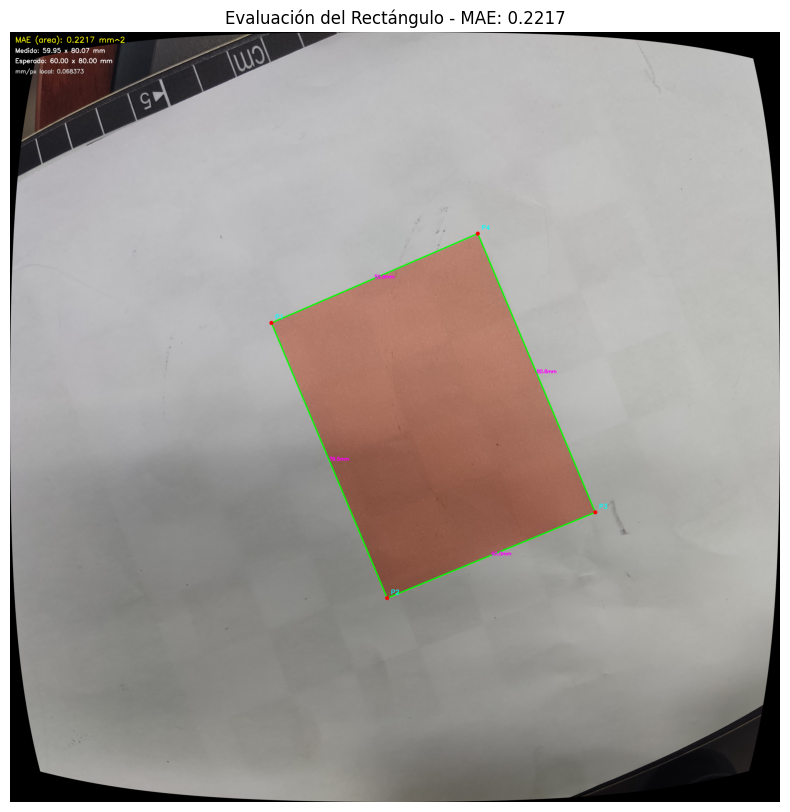


[OK] Visualización guardada en: ./evaluation_results/evaluation_rectangle.jpg
[INFO] Calibración cargada:
  - mm/px global (PKL): 0.075385
  - K:
[[3.52000418e+03 0.00000000e+00 1.49312647e+03]
 [0.00000000e+00 3.52047661e+03 1.45385529e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

[INFO] Coordenadas originales del rectángulo:
  Punto 1: (1024.00, 1135.00)
  Punto 2: (1470.00, 2196.00)
  Punto 3: (2274.00, 1866.00)
  Punto 4: (1820.00, 790.00)

[INFO] Coordenadas corregidas del rectángulo:
  Punto 1: (1018.48, 1133.24)
  Punto 2: (1469.46, 2205.50)
  Punto 3: (2280.85, 1871.81)
  Punto 4: (1822.77, 785.48)

[INFO] Escala mm/px calculada localmente:
  - mm/px local (promedio): 0.068373
  - mm/px std: 0.000331
  - Diferencia con global: 0.007011

[INFO] Lados del rectángulo medidos (con mm/px local):
  Lado 1: 1163.24 px = 79.53 mm (esperado: 80.00 mm, error: 0.47 mm)
  Lado 2: 877.33 px = 59.99 mm (esperado: 60.00 mm, error: 0.01 mm)
  Lado 3: 1178.95 px = 80.61 mm (esperado: 

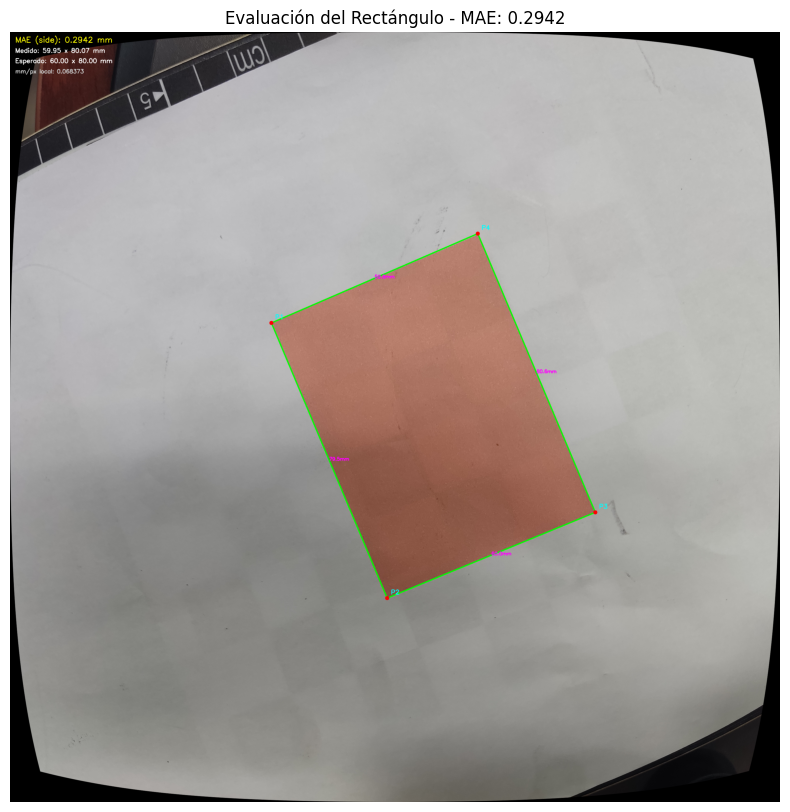


[OK] Visualización guardada en: ./evaluation_results/evaluation_rectangle.jpg


In [ ]:
img_path = ".."
pts_txt  = ".."
calibration_pkl = "calibration.pkl"

width_mm = 80.0
height_mm = 60.0

mae_treshold_mm=0.5

mae_mode="area"

# Area-based MAE
results = evaluate_rectangle_photogrammetry(
    image_path=img_path,
    coords_txt_path=pts_txt,
    calib_pkl=calibration_pkl,
    rect_width_mm=width_mm,
    rect_height_mm=height_mm,
    mae_treshold_mm=mae_treshold_mm,
    mae_mode=mae_mode,
    visualize=True
)

mae_mode="side"

# Side-based MAE
results = evaluate_rectangle_photogrammetry(
    image_path=img_path,
    coords_txt_path=pts_txt,
    calib_pkl=calibration_pkl,
    rect_width_mm=width_mm,
    rect_height_mm=height_mm,
    mae_treshold_mm=mae_treshold_mm,
    mae_mode=mae_mode,
    visualize=True
)

## Instance segmentation

In [ ]:
from ultralytics import YOLO
import os
import torch
from roboflow import Roboflow
from IPython.display import display, Image
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
from sahi import AutoDetectionModel
from sahi.predict import predict
from sahi.utils.cv import read_image
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import visualize_object_predictions
import cv2
import pickle
import numpy as np
from glob import glob
from tqdm import tqdm
import traceback
from __future__ import annotations
from typing import Any, Dict, List, Tuple, Optional, Set
import random

MODEL_PATH = '...'
MODEL_TYPE = '...'


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# dataset download
dataset = None

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shirmp-food-18 in yolov8:: 100%|██████████| 6059/6059 [00:00<00:00, 7497.25it/s]


### Evaluation with mIoU + F1

In [ ]:
model = YOLO(MODEL_PATH)

results = model.predict(source=dataset.location + "/valid/images", save=True, save_txt=True ,conf=0.7, imgsz=200)

In [ ]:
def compute_iou_binary(mask_pred: np.ndarray, mask_gt: np.ndarray) -> float:
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    if union == 0:
        return float(intersection == 0)
    return intersection / union


def compute_f1_pixel(mask_pred: np.ndarray, mask_gt: np.ndarray) -> float:
    tp = np.logical_and(mask_pred == 1, mask_gt == 1).sum()
    fp = np.logical_and(mask_pred == 1, mask_gt == 0).sum()
    fn = np.logical_and(mask_pred == 0, mask_gt == 1).sum()

    if tp + fp + fn == 0:
        return 1.0

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    return 2 * precision * recall / (precision + recall + 1e-9)


def polygon_txt_to_mask(label_path: str, image_shape: tuple) -> np.ndarray:
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) <= 5:
                continue

            poly = np.array(
                list(map(float, parts[5:])),
                dtype=np.float32
            ).reshape(-1, 2)

            poly[:, 0] *= w
            poly[:, 1] *= h
            cv2.fillPoly(mask, [poly.astype(np.int32)], 1)

    return mask


def get_file_mapping(pred_folder: str, gt_folder: str):
    gt_dict = {os.path.basename(f): f for f in glob(gt_folder + "/*.txt")}
    pred_dict = {os.path.basename(f): f for f in glob(pred_folder + "/*.txt")}
    common_files = sorted(set(gt_dict.keys()) & set(pred_dict.keys()))
    return pred_dict, gt_dict, common_files


def load_image(image_folder: str, filename: str):
    image_name = filename.replace(".txt", ".jpg")
    img_path = os.path.join(image_folder, image_name)

    if not os.path.exists(img_path):
        image_name = filename.replace(".txt", ".png")
        img_path = os.path.join(image_folder, image_name)
    
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Imagen no encontrada: {img_path}")
        return None, None
    
    return img, image_name


def classify_iou(iou: float) -> str:
    if iou < 0.70:
        return "⚠️ Bajo"
    elif iou < 0.85:
        return "⚡ Aceptable"
    else:
        return "✅ Excelente"


def evaluate_single_image(pred_file: str, gt_file: str, image_folder: str, filename: str):
    img, image_name = load_image(image_folder, filename)
    
    if img is None:
        return None
    
    h, w = img.shape[:2]

    mask_pred = polygon_txt_to_mask(pred_file, (h, w))
    mask_gt = polygon_txt_to_mask(gt_file, (h, w))

    iou = compute_iou_binary(mask_pred, mask_gt)
    f1 = compute_f1_pixel(mask_pred, mask_gt)

    comment = classify_iou(iou)
    image_name = image_name.split('_jpg')[0]

    return {
        'image': image_name,
        'iou': iou,
        'f1': f1,
        'comment': comment
    }

In [ ]:
pred_folder = "..."

gt_folder = os.path.join(dataset.location, "valid", "labels")
image_folder = os.path.join(dataset.location, "valid", "images")

pred_dict, gt_dict, common_files = get_file_mapping(pred_folder, gt_folder)

print(f"Total archivos emparejados correctamente: {len(common_files)}")

results = []

for filename in tqdm(common_files):
    pred_file = pred_dict[filename]
    gt_file = gt_dict[filename]

    result = evaluate_single_image(pred_file, gt_file, image_folder, filename)
        
    if result is not None:
        results.append(result)

mean_iou = np.mean([r['iou'] for r in results])
mean_f1 = np.mean([r['f1'] for r in results])

print("================================================================================")
print("RESULTADOS DE EVALUACIÓN - FORMATO MARKDOWN")
print("================================================================================")

print("| Imagen/Test set | mIoU | F1-score pixel-level | Comentario |")
print("|-----------------|------|----------------------|------------|")

for r in results:
    print(f"| {r['image']:<15} | {r['iou']:.4f} | {r['f1']:.4f} | {r['comment']:<10} |")

print("|-----------------|------|----------------------|------------|")
print(f"| **PROMEDIO GLOBAL** | **{mean_iou:.4f}** | **{mean_f1:.4f}** | {'Final' if mean_iou > 0.85 else '⚡ Final'} |")

print("================================================================================")
print(f"mIoU Global: {mean_iou:.4f}")
print(f"F1-score Global: {mean_f1:.4f}")
print(f"Total imágenes evaluadas: {len(results)}")
print("================================================================================")

Total archivos emparejados correctamente: 356


100%|██████████| 356/356 [00:01<00:00, 280.55it/s]


RESULTADOS DE EVALUACIÓN - FORMATO MARKDOWN

| Imagen/Test set | mIoU | F1-score pixel-level | Comentario |
|-----------------|------|----------------------|------------|
| EXM35_22mm_1_10 | 0.8928 | 0.9433 | ✅ Excelente |
| EXM35_22mm_1_10 | 0.9297 | 0.9636 | ✅ Excelente |
| EXM35_22mm_1_10 | 0.9422 | 0.9703 | ✅ Excelente |
| EXM35_22mm_1_10 | 0.9106 | 0.9532 | ✅ Excelente |
| EXM35_22mm_1_11 | 0.9107 | 0.9533 | ✅ Excelente |
| EXM35_22mm_1_11 | 0.9704 | 0.9850 | ✅ Excelente |
| EXM35_22mm_1_11 | 0.9523 | 0.9755 | ✅ Excelente |
| EXM35_22mm_1_11 | 0.9068 | 0.9511 | ✅ Excelente |
| EXM35_22mm_1_12 | 0.9577 | 0.9784 | ✅ Excelente |
| EXM35_22mm_1_12 | 0.9374 | 0.9677 | ✅ Excelente |
| EXM35_22mm_1_12 | 0.9214 | 0.9591 | ✅ Excelente |
| EXM35_22mm_1_12 | 0.9507 | 0.9747 | ✅ Excelente |
| EXM35_22mm_1_22 | 0.8768 | 0.9343 | ✅ Excelente |
| EXM35_22mm_1_22 | 0.8838 | 0.9383 | ✅ Excelente |
| EXM35_22mm_1_22 | 0.8484 | 0.9180 | ⚡ Aceptable |
| EXM35_22mm_1_22 | 0.9039 | 0.9495 | ✅ Excelent

### Inference with SAHI (Sliced Aided Hyper Inference)

This module implements a segmentation‑aware inference pipeline for small object detection in high‑resolution images using SAHI with YOLOv8.

The pipeline addresses the typical degradation of small‑object detection in large images by:

- Slicing the image into overlapping patches  
- Performing independent inference per slice  
- Merging detections back into the original image using robust post‑processing

#### 1. Visualization Utilities

**`random_colors(N, cmap_name='tab20')`**  
Generates N visually distinct colors using Matplotlib colormaps. Colors are converted from RGB to BGR for OpenCV compatibility and randomly shuffled to reduce adjacency similarity.

**`draw_sahi_grid(image, slice_width, slice_height, overlap, color, alpha)`**  
Draws the slicing grid on the original image to visualize how SAHI partitions the image. The stride is computed based on the specified overlap ratio.

**`show_segmentation_masks(image, preds, path_name, overlap, slice_dim, ...)`**  
Displays segmentation masks with:

- Unique colors per object  
- Boundary contours  
- Highlighted overlapping pixels between masks  
- Optional SAHI grid overlay  

This function is intended for qualitative analysis only.

**`read_image(image_path)`**  
Reads and displays the input image, performing BGR→RGB color conversion for correct display with Matplotlib.

#### 2. SAHI Inference Pipeline

**`make_inference_sahi(...)`**  
Runs the complete sliced inference workflow.

**Configurable parameters:**

- `slice_dim`: Patch (tile) size in pixels  
- `overlap`: Overlap ratio between patches (0–1)  
- `conf_thres`: Confidence threshold to filter weak detections  
- `visualize`: Controls visualization of intermediate results  

**Workflow:**

1. **Model loading**: Initializes YOLOv8 with pretrained weights  
2. **Image loading**: Validates dimensions and format  
3. **Sliced inference**: Runs `get_sliced_prediction` with:
   - `postprocess_type="NMS"`: Applies Non‑Maximum Suppression to remove slice‑level duplicates  
   - `postprocess_match_threshold=...`: High IoU threshold for conservative merging  
   - `perform_standard_pred=True`: Also runs inference on the full image  
4. **Initial visualization**: Shows detections before filtering  
5. **Grouping and cleaning**: Applies `apply_grouping_keep_largest` with two sequential filters  
6. **Final visualization**: Shows detections after post‑processing  
7. **Pixel counting**: Computes total segmented area and number of detected objects  

**Return:** `(total_segmented_pixels, number_of_detected_objects)`

#### 3. Post‑processing: Duplicate Filtering

**`apply_grouping_keep_largest(...)`**  
Implements a two‑stage strategy to remove redundant detections generated by slicing:

**STEP 1: IoU‑based grouping**

- Groups detections of the same class with IoU ≥ threshold
- Uses transitive connectivity: if A overlaps B and B overlaps C, all form one group
- For each group, keeps only the object with the **largest area** (criterion: area > score)  
- Removes fragments and partial detections of the same object  

**STEP 2: Containment filtering**

- Detects small objects contained within larger ones  
- Computes the percentage of the small object’s area contained in the large one  
- If containment ≥ threshold, removes the small object  
- Only applied between objects of the same class  
- Prevents nested duplicates not caught due to low IoU  

**Robust validations:**

- Full type hints with runtime type checks  
- Flexible handling of bounding‑box structures (xyxy, minx/miny, left/top, etc.)  
- Safe extraction of scores and `class_id`s from different attribute layouts  
- Precise IoU and containment metric calculations  

**Returned metrics:**

```json
{
  "total_before": int,              // Initial detections
  "total_after": int,               // Final detections
  "groups_formed": int,             // Number of groups identified
  "removed_by_grouping": int,       // Removed via IoU grouping
  "removed_by_containment": int,    // Removed via containment
  "removed": int,                   // Total removed
  "grouping_iou_threshold": float,
  "containment_threshold": float
}
```

In [ ]:
def apply_grouping_keep_largest(
    sahi_result: Any,
    image_width: int,
    image_height: int,
    grouping_iou_threshold: float = 0.35,
    containment_threshold: float = 0.6,
    enable_containment_filter: bool = True,
) -> Tuple[Any, Dict[str, Any]]:
    """
    Two-stage duplicate suppression strategy for slice-based object detection.

    Stage 1 — IoU-based grouping:
        Detections of the same class with IoU >= threshold are grouped.
        Only the largest-area detection per group is retained.

    Stage 2 — Containment-based pruning (optional):
        Smaller detections largely contained within bigger ones are removed.

    Parameters:
    sahi_result : Any - SAHI result-like object with `.object_prediction_list`.
    image_width, image_height : int - Image dimensions in pixels.
    grouping_iou_threshold : float, optional - IoU threshold to group detections as same object (default 0.35).
    containment_threshold : float, optional - If object A is X% contained in object B (and A is smaller), remove A (default 0.6).
    enable_containment_filter : bool, optional - Enable containment-based filtering after grouping (default True).

    Returns:
    (sahi_result, resumen) : Tuple[Any, Dict[str, Any]] - Updated sahi_result and summary metrics.
    """

    # Validations
    if not hasattr(sahi_result, "object_prediction_list"):
        raise ValueError("`sahi_result` must have `.object_prediction_list`.")
    if not isinstance(sahi_result.object_prediction_list, list):
        raise ValueError("`sahi_result.object_prediction_list` must be a list.")
    if not (isinstance(image_width, int) and isinstance(image_height, int)) or image_width <= 0 or image_height <= 0:
        raise ValueError("`image_width` and `image_height` must be positive integers.")
    if not (0.0 <= grouping_iou_threshold <= 1.0):
        raise ValueError("`grouping_iou_threshold` must be in [0.0, 1.0].")
    if not (0.0 <= containment_threshold <= 1.0):
        raise ValueError("`containment_threshold` must be in [0.0, 1.0].")

    # Utilities
    def _bbox_xyxy_from_obj(obj: Any) -> Optional[np.ndarray]:
        if not hasattr(obj, "bbox"):
            bb = getattr(obj, "box", None)
        else:
            bb = obj.bbox
        if bb is None:
            return None
        if hasattr(bb, "to_xyxy") and callable(getattr(bb, "to_xyxy")):
            xyxy = bb.to_xyxy()
            arr = np.asarray(xyxy, dtype=float)
            if arr.shape == (4,):
                return arr
        for names in (("minx", "miny", "maxx", "maxy"), ("left", "top", "right", "bottom"), ("x1", "y1", "x2", "y2")):
            if all(hasattr(bb, n) for n in names):
                return np.array([getattr(bb, names[0]), getattr(bb, names[1]), getattr(bb, names[2]), getattr(bb, names[3])], dtype=float)
        if isinstance(bb, (list, tuple, np.ndarray)) and len(bb) == 4:
            return np.asarray(bb, dtype=float)
        pts = getattr(obj, "points", None)
        if isinstance(pts, (list, tuple, np.ndarray)) and len(pts) > 0:
            pts = np.asarray(pts, dtype=float)
            if pts.ndim == 2 and pts.shape[1] >= 2:
                return np.array([np.min(pts[:, 0]), np.min(pts[:, 1]), np.max(pts[:, 0]), np.max(pts[:, 1])], dtype=float)
        return None

    def _get_score(obj: Any) -> float:
        sc = getattr(obj, "score", None)
        if sc is None:
            sc = getattr(obj, "confidence", None)
        if isinstance(sc, (int, float, np.floating)):
            return float(sc)
        if hasattr(sc, "value"):
            return float(sc.value)
        return float(getattr(obj, "conf", 0.0))

    def _get_class_id(obj: Any) -> int:
        cat = getattr(obj, "category", None)
        if cat is not None and hasattr(cat, "id"):
            return int(cat.id)
        cid = getattr(obj, "category_id", None)
        if isinstance(cid, (int, np.integer)):
            return int(cid)
        if isinstance(cat, (int, np.integer)):
            return int(cat)
        return int(getattr(obj, "label", 0))

    def _compute_iou(box1: np.ndarray, box2: np.ndarray) -> float:
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        inter_w = max(0.0, x2 - x1)
        inter_h = max(0.0, y2 - y1)
        inter = inter_w * inter_h
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - inter
        return inter / union if union > 0 else 0.0

    def _compute_containment(box_small: np.ndarray, box_large: np.ndarray) -> float:
        x1 = max(box_small[0], box_large[0])
        y1 = max(box_small[1], box_large[1])
        x2 = min(box_small[2], box_large[2])
        y2 = min(box_small[3], box_large[3])
        inter_w = max(0.0, x2 - x1)
        inter_h = max(0.0, y2 - y1)
        intersection = inter_w * inter_h
        small_area = (box_small[2] - box_small[0]) * (box_small[3] - box_small[1])
        if small_area <= 0:
            return 0.0
        return intersection / small_area

    # STEP 1: Extract object info
    objects_info = []
    for obj in sahi_result.object_prediction_list:
        bbox = _bbox_xyxy_from_obj(obj)
        if bbox is None:
            continue
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        score = _get_score(obj)
        cls_id = _get_class_id(obj)

        objects_info.append({
            'obj': obj,
            'bbox': bbox,
            'area': area,
            'score': score,
            'class': cls_id
        })

    total_before = len(objects_info)

    if not objects_info:
        sahi_result.object_prediction_list = []
        return sahi_result, {
            "total_before": 0,
            "total_after": 0,
            "groups_formed": 0,
            "removed_by_grouping": 0,
            "removed_by_containment": 0,
            "removed": 0,
            "grouping_iou_threshold": grouping_iou_threshold,
            "containment_threshold": containment_threshold,
        }

    # STEP 2: Group by IoU (same class)
    print(f"STEP 2: Grouping {len(objects_info)} objects (IoU={grouping_iou_threshold})...")
    groups: List[List[int]] = []
    assigned = set()

    for i, info_i in enumerate(objects_info):
        if i in assigned:
            continue

        group = [i]
        assigned.add(i)

        for j, info_j in enumerate(objects_info):
            if j in assigned or info_i['class'] != info_j['class']:
                continue

            max_iou = 0.0
            for member_idx in group:
                iou = _compute_iou(objects_info[member_idx]['bbox'], info_j['bbox'])
                max_iou = max(max_iou, iou)

            if max_iou >= grouping_iou_threshold:
                group.append(j)
                assigned.add(j)

        groups.append(group)

    print(f"Formed {len(groups)} groups")

    # STEP 3: Keep-largest per group
    survivors_after_grouping = []
    removed_by_grouping = 0

    for group in groups:
        if len(group) == 1:
            survivors_after_grouping.append(objects_info[group[0]])
        else:
            group_infos = [objects_info[idx] for idx in group]
            largest = max(group_infos, key=lambda x: (x['area'], x['score']))
            survivors_after_grouping.append(largest)
            removed_by_grouping += len(group) - 1

    print(f"Removed {removed_by_grouping} smaller objects from groups")

    # STEP 4: Containment filter
    removed_by_containment = 0

    if enable_containment_filter and len(survivors_after_grouping) > 1:
        print(f"STEP 4: Analyzing containment (threshold={containment_threshold})...")
        to_remove: Set[int] = set()

        for i, obj_i in enumerate(survivors_after_grouping):
            if i in to_remove:
                continue

            for j, obj_j in enumerate(survivors_after_grouping):
                if i == j or j in to_remove:
                    continue

                if obj_i['class'] != obj_j['class']:
                    continue

                if obj_i['area'] < obj_j['area']:
                    small, large = obj_i, obj_j
                    small_idx = i
                elif obj_j['area'] < obj_i['area']:
                    small, large = obj_j, obj_i
                    small_idx = j
                else:
                    continue

                containment = _compute_containment(small['bbox'], large['bbox'])

                if containment >= containment_threshold:
                    to_remove.add(small_idx)
                    removed_by_containment += 1
                    break

        final_survivors = [obj for i, obj in enumerate(survivors_after_grouping) if i not in to_remove]
        print(f"Eliminados {removed_by_containment} objetos por contención")
    else:
        final_survivors = survivors_after_grouping

    sahi_result.object_prediction_list = [obj['obj'] for obj in final_survivors]

    resumen = {
        "total_before": total_before,
        "total_after": len(final_survivors),
        "groups_formed": len(groups),
        "removed_by_grouping": removed_by_grouping,
        "removed_by_containment": removed_by_containment,
        "removed": removed_by_grouping + removed_by_containment,  # <- AGREGADO
        "grouping_iou_threshold": grouping_iou_threshold,
        "containment_threshold": containment_threshold,
    }
    return sahi_result, resumen

PASO 1: Agrupando 5 objetos (IoU=0.35)...
Formados 5 grupos
Eliminados 0 objetos más pequeños de grupos
PASO 2: Analizando contención (threshold=0.6)...
Eliminados 2 objetos por contención

Resumen: {'total_before': 5, 'total_after': 3, 'groups_formed': 5, 'removed_by_grouping': 0, 'removed_by_containment': 2, 'removed': 2, 'grouping_iou_threshold': 0.35, 'containment_threshold': 0.6}
Objetos finales: 3
  0: score=0.850, cat=1, bbox=(200.0,200.0,350.0,350.0)
  1: score=0.800, cat=1, bbox=(500.0,500.0,700.0,700.0)
  2: score=0.700, cat=2, bbox=(800.0,800.0,850.0,850.0)


In [ ]:
def random_colors(N: int, cmap_name: str = 'tab20') -> list:
    cmap = plt.get_cmap(cmap_name)
    colors = [tuple(int(255 * c) for c in cmap(i / N)[:3][::-1]) for i in range(N)]
    random.shuffle(colors)
    return colors

def draw_sahi_grid(
    image: np.ndarray,
    slice_width: int,
    slice_height: int,
    overlap: float = 0.5,
    color: tuple = (255, 255, 255),
    alpha: float = 0.3
) -> np.ndarray:
    """
    Draws SAHI slicing grid on the original image. Uses semi-transparent lines to avoid covering masks.

    Args:
    - image (np.ndarray): Input image in BGR format.
    - slice_width (int): Width of each slice in pixels.
    - slice_height (int): Height of each slice in pixels.
    - overlap (float): Overlap ratio between slices (0–1).
    - color (tuple): Grid line color in BGR format.
    - alpha (float): Grid transparency (0=invisible, 1=opaque).

    Returns:
    - np.ndarray: Image with grid overlay.
    """
    overlay = image.copy()
    H, W = image.shape[:2]

    step_x = int(slice_width * (1 - overlap))
    step_y = int(slice_height * (1 - overlap))

    for x in range(0, W, step_x):
        cv2.line(overlay, (x, 0), (x, H), color, 1)
    for y in range(0, H, step_y):
        cv2.line(overlay, (0, y), (W, y), color, 1)

    blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    return blended


def show_segmentation_masks(
    image: np.ndarray,
    preds: list,
    path_name: str,
    overlap: float,
    slice_dim: int,
    *,
    base_alpha: float = 0.5,
    overlap_color: tuple = (255, 0, 255),
    overlap_min_count: int = 2,
    border_thickness: int = 1,
) -> None:
    """
    Displays segmentation masks with unique colors, contours, and overlap highlights.

    Args:
    - image (np.ndarray): Input image in BGR format.
    - preds (list): List of prediction objects with mask attributes.
    - path_name (str): Path to the image (used for title).
    - overlap (float): Overlap ratio used for SAHI slicing.
    - slice_dim (int): Slice dimension for grid visualization.
    - base_alpha (float): Mask transparency (0=transparent, 1=opaque).
    - overlap_color (tuple): Color for overlapping pixels in BGR.
    - overlap_min_count (int): Minimum mask count to consider pixel as overlapping.
    - border_thickness (int): Thickness of mask contours.
    """
    overlay = image.copy()
    H, W = image.shape[:2]
    colored_mask = np.zeros_like(image, dtype=np.uint8)

    masks = []
    for obj in preds:
        if getattr(obj, "mask", None) is not None:
            m = getattr(obj.mask, 'bool_mask', obj.mask)
            m = (m.astype(bool))
            if m.ndim == 2 and m.shape[0] == H and m.shape[1] == W:
                masks.append(m)

    if not masks:
        base_name = os.path.basename(path_name)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'No masks: {base_name}')
        plt.tight_layout()
        plt.show()
        return

    colors = random_colors(len(masks))

    for mask, color in zip(masks, colors):
        for c in range(3):
            colored_mask[:, :, c] = np.where(mask, color[c], colored_mask[:, :, c])

        mask_uint8 = mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(colored_mask, contours, -1, color, thickness=border_thickness)

    count_map = np.zeros((H, W), dtype=np.uint16)
    for m in masks:
        count_map += m.astype(np.uint16)
    overlap_mask = count_map >= overlap_min_count

    if overlap_mask.any():
        colored_mask[overlap_mask] = overlap_color

    result = cv2.addWeighted(overlay, 1 - base_alpha, colored_mask, base_alpha, 0)

    base_name = os.path.basename(path_name)
    plt.figure(figsize=(30, 30))
    grid_result = draw_sahi_grid(result, slice_dim, slice_dim, overlap)
    plt.imshow(cv2.cvtColor(grid_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    title = f'Segmentation Mask: {base_name}'
    if overlap_mask.any():
        px_overlap = int(overlap_mask.sum())
        title += f'  |  Overlapping: {px_overlap} px'
    plt.title(title)
    plt.tight_layout()
    plt.show()


def read_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: No se pudo cargar la imagen en la ruta: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def load_detection_model(
    model_path: str,
    device: str = "cuda:0",
    conf_thres: float = 0.865,
    image_size: int = 960,
    model_type: str = "yolov8",
    verbose: bool = True
) -> Any:
    """
    Loads a YOLOv8 detection model for inference.

    Args:
    - model_path (str): Path to model weights (.pt or .onnx).
    - device (str): Execution device ('cuda:0' or 'cpu').
    - conf_thres (float): Minimum confidence threshold for detections.
    - image_size (int): Model input size.
    - model_type (str): Model architecture type.
    - verbose (bool): If True, prints loading status.

    Returns: Loaded detection model instance.
    """
    if verbose:
        print(f"Loading {model_type.upper()} model for sliced inference...")
    
    detection_model = AutoDetectionModel.from_pretrained(
        model_type=model_type,
        model_path=model_path,
        device=device,
        confidence_threshold=conf_thres,
        image_size=image_size,
    )
    
    if verbose:
        print(f"Model loaded successfully from: {model_path}")
    
    return detection_model


def run_sliced_prediction(
    image: np.ndarray,
    detection_model: Any,
    slice_dim: int = 300,
    overlap: float = 0.5,
    postprocess_config: Optional[dict] = None,
    verbose: bool = True
) -> Any:
    """
    Executes SAHI sliced prediction on an image.

    Args:
    - image (np.ndarray): Input image in RGB format.
    - detection_model (Any): Loaded detection model.
    - slice_dim (int): Slice dimension for tiling.
    - overlap (float): Overlap ratio between slices (0–1).
    - postprocess_config (dict, optional): Custom postprocessing parameters.
    - verbose (bool): If True, prints progress.

    Returns: SAHI prediction result with object_prediction_list.
    """
    
    if verbose:
        print(f"Running sliced inference (slice={slice_dim}px, overlap={overlap})...")
    
    sahi_results = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_dim,
        slice_width=slice_dim,
        overlap_height_ratio=overlap,
        overlap_width_ratio=overlap,
        verbose=verbose,
        **postprocess_config
    )
    
    if verbose:
        print(f"Inference completed. Initial detections: {len(sahi_results.object_prediction_list)}")
    
    return sahi_results


def apply_detection_filtering(
    sahi_results: Any,
    image_width: int,
    image_height: int,
    grouping_iou_threshold: float = 0.25,
    containment_threshold: float = 0.55,
    enable_containment_filter: bool = True,
    verbose: bool = True
) -> Tuple[Any, dict]:
    """
    Applies grouping and containment filtering to remove duplicate detections.

    Args:
    - sahi_results (Any): Raw SAHI prediction results.
    - image_width (int): Image width in pixels.
    - image_height (int): Image height in pixels.
    - grouping_iou_threshold (float): IoU threshold for grouping.
    - containment_threshold (float): Containment ratio threshold.
    - enable_containment_filter (bool): Enable containment-based filtering.
    - verbose (bool): If True, prints filtering summary.

    Returns:
    - Tuple[Any, dict]: Filtered results and summary metrics.
    """
    if verbose:
        print("Applying grouping and detection cleanup...")
    
    result, summary = apply_grouping_keep_largest(
        sahi_result=sahi_results,
        image_width=image_width,
        image_height=image_height,
        grouping_iou_threshold=grouping_iou_threshold,
        containment_threshold=containment_threshold,
        enable_containment_filter=enable_containment_filter,
    )
    
    if verbose:
        total_before = summary.get("total_before", 0)
        total_after = summary.get("total_after", 0)
        removed = summary.get("removed", 0)
        
        print("Grouping summary:")
        print(f"   Total before: {total_before}")
        print(f"   Total after: {total_after}")
        print(f"   Removed: {removed}")
    
    return result, summary


def compute_segmentation_metrics(predictions: list) -> Tuple[int, int]:
    """
    Computes total segmented pixels and number of detected objects.

    Args:
    - predictions (list): List of prediction objects with mask attributes.

    Returns:
    - Tuple[int, int]: (total_segmented_pixels, number_of_objects)
    """
    total_pixels = 0
    for obj in predictions:
        if hasattr(obj, 'mask') and obj.mask is not None:
            mask = getattr(obj.mask, 'bool_mask', obj.mask)
            total_pixels += int(np.sum(mask))
    
    num_objects = len(predictions)
    return total_pixels, num_objects


def make_inference_sahi(
    image_path: str,
    model_path: str,
    device: str = "cuda:0",
    conf_thres: float = 0.1,
    image_size: int = 600,
    slice_dim: int = 200,
    overlap: float = 0.5,
    grouping_iou_threshold: float = 0.43234,
    containment_threshold: float = 0.4343,
    enable_containment_filter: bool = True,
    postprocess_config: Optional[dict] = None,
    visualize: bool = True,
    verbose: bool = True,
) -> Tuple[int, int, dict]:
    """
    Runs sliced inference (SAHI) on an image using YOLOv8.

    Args:
        image_path (str): Absolute path to the image to process.
        model_path (str): Path to YOLOv8 model (.pt or .onnx).
        device (str): Execution device ('cuda:0' or 'cpu').
        conf_thres (float): Minimum confidence threshold for detections.
        image_size (int): Model input size.
        slice_dim (int): Size of slices (tiles) for sliced inference.
        overlap (float): Overlap ratio between slices (0–1).
        grouping_iou_threshold (float): IoU threshold for grouping duplicates.
        containment_threshold (float): Containment ratio threshold for filtering.
        enable_containment_filter (bool): Enable containment-based filtering.
        postprocess_config (dict, optional): Custom SAHI postprocessing config.
        visualize (bool): If True, displays segmented masks.
        verbose (bool): If True, prints detailed logs.

    Returns:
        Tuple[int, int, dict]: (total_segmented_pixels, number_detected_objects, summary_metrics)
    """
    detection_model = load_detection_model(
        model_path=model_path,
        device=device,
        conf_thres=conf_thres,
        image_size=image_size,
        verbose=verbose
    )
    
    image = read_image(image_path)
    image_height, image_width = image.shape[:2]
    
    if verbose:
        print(f"Image loaded: {image_path}")
        print(f"Dimensions: {image_width}x{image_height}px")
    
    sahi_results = run_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_dim=slice_dim,
        overlap=overlap,
        postprocess_config=postprocess_config,
        verbose=verbose
    )
    
    if visualize:
        show_segmentation_masks(
            image, 
            sahi_results.object_prediction_list, 
            image_path, 
            overlap, 
            slice_dim
        )
    
    result, summary = apply_detection_filtering(
        sahi_results=sahi_results,
        image_width=image_width,
        image_height=image_height,
        grouping_iou_threshold=grouping_iou_threshold,
        containment_threshold=containment_threshold,
        enable_containment_filter=enable_containment_filter,
        verbose=verbose
    )
    
    if visualize:
        show_segmentation_masks(
            image, 
            result.object_prediction_list, 
            image_path, 
            overlap, 
            slice_dim
        )
    
    total_pixels, num_objects = compute_segmentation_metrics(result.object_prediction_list)
    
    if verbose:
        print(f"Final detected objects: {num_objects}")
        print(f"Total segmented pixels: {total_pixels}")
    
    return total_pixels, num_objects, summary

In [ ]:
# Call to make_inference_sahi function example

### Evaluacion de conteo de pellets

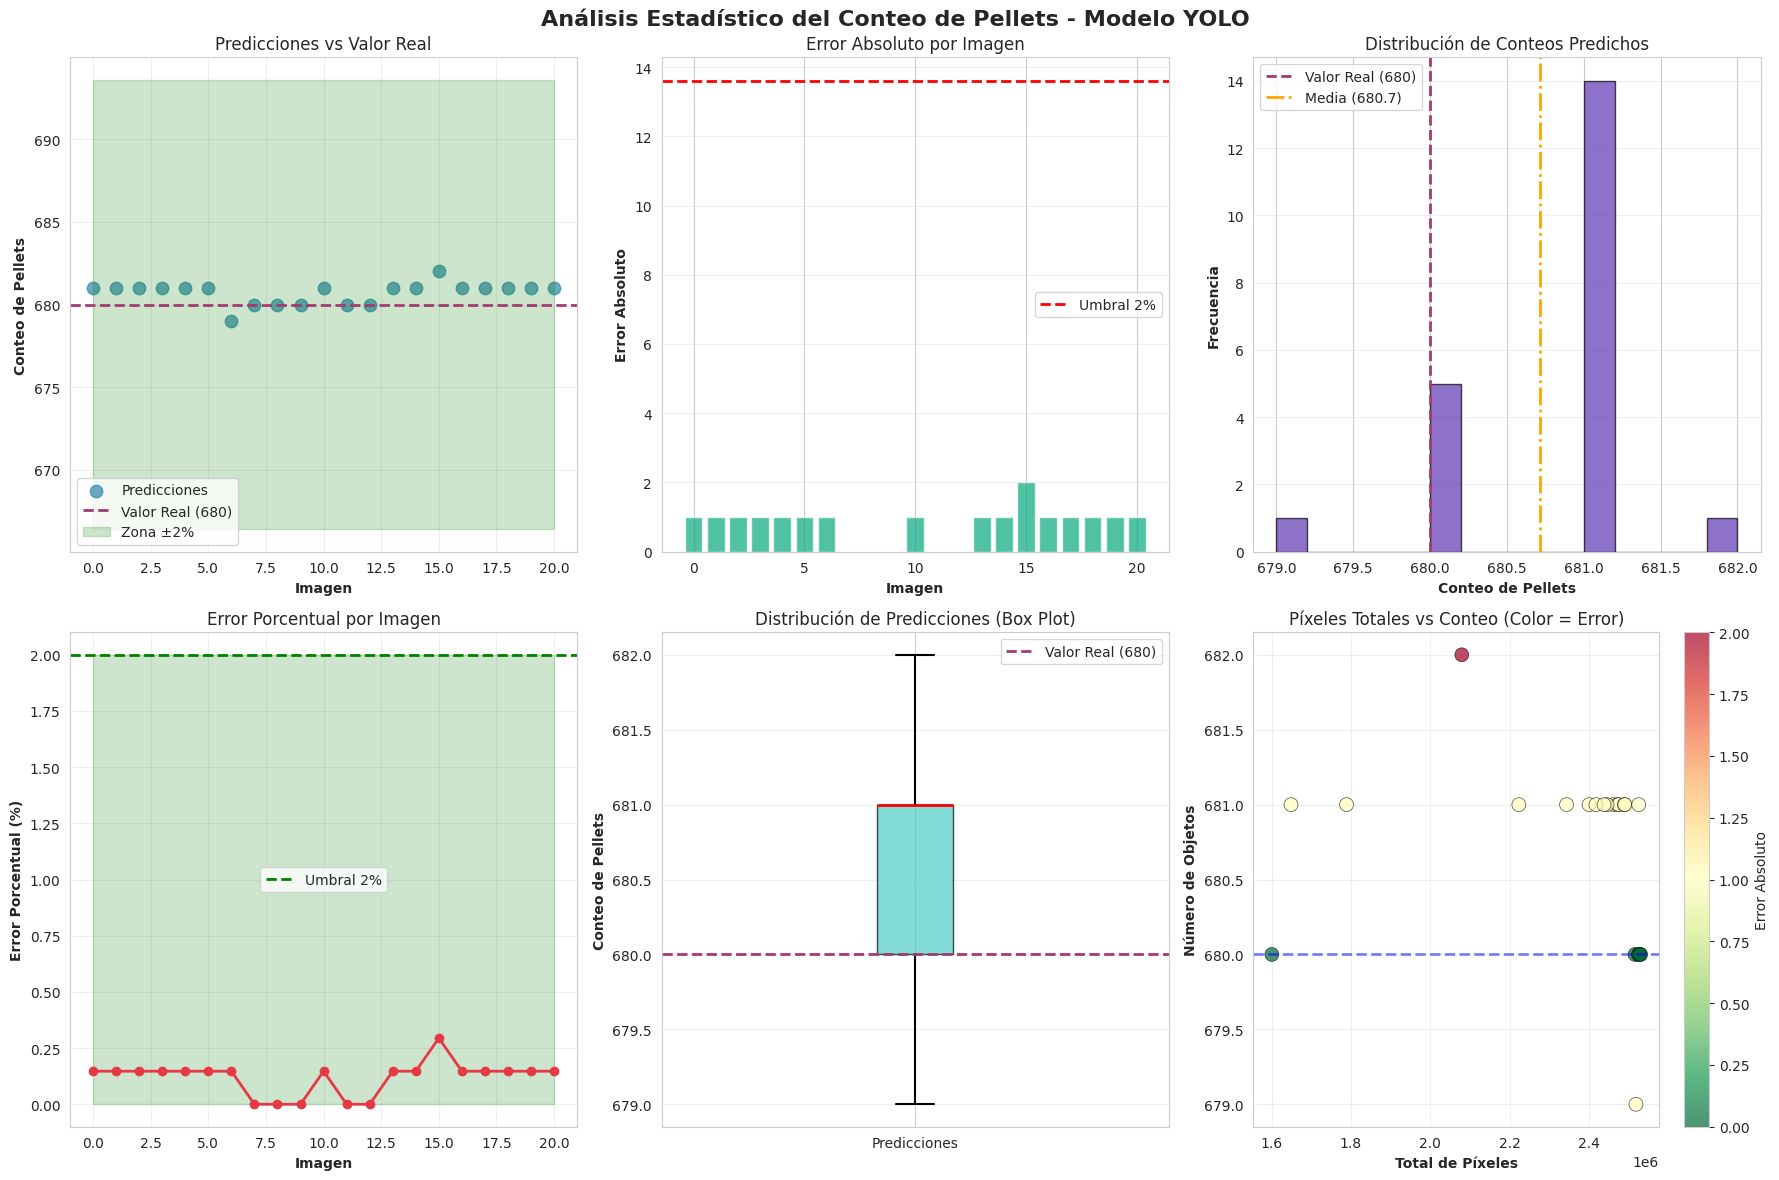


RESUMEN ESTADÍSTICO DEL MODELO
Total de imágenes: 21
Valor real de pellets: 680

--- Predicciones ---
Media: 680.71
Mediana: 681.00
Desviación estándar: 0.64
Mínimo: 679
Máximo: 682

--- Errores ---
MAE (Error Absoluto Medio): 0.81 pellets
MAPE (Error Porcentual Medio): 0.12%
Error máximo: 2 pellets
Error mínimo: 0 pellets

Imágenes dentro del ±2%: 21 / 21
Cumple criterio (MAPE ≤ 2%): ✓ SÍ


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

df_eval = None # DataFrame with evaluation results
GT_OBJECT_COUNT = 100  # Ground truth object count

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Statistical Analysis of Object Count – Segmentation Model',
             fontsize=16, fontweight='bold')

# 1. Predictions vs Ground Truth
ax1 = axes[0, 0]
ax1.scatter(range(len(df_eval)), df_eval['Number_of_Objects'],
           alpha=0.7, s=80, color='#2E86AB', label='Predictions')
ax1.axhline(y=GT_OBJECT_COUNT, color='#A23B72',
           linestyle='--', linewidth=2, label=f'Ground Truth ({GT_OBJECT_COUNT})')
ax1.fill_between(range(len(df_eval)),
                 GT_OBJECT_COUNT - GT_OBJECT_COUNT*0.02,
                 GT_OBJECT_COUNT + GT_OBJECT_COUNT*0.02,
                 alpha=0.2, color='green', label='±2% Tolerance')
ax1.set_xlabel('Image', fontweight='bold')
ax1.set_ylabel('Object Count', fontweight='bold')
ax1.set_title('Predictions vs Ground Truth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Absolute Error per Image
ax2 = axes[0, 1]
colors = ['#06A77D' if x <= 2 else '#F77E21' for x in df_eval['Percentage_Error']]
bars = ax2.bar(range(len(df_eval)), df_eval['Absolute_Error'],
               color=colors, alpha=0.7)
ax2.axhline(y=GT_OBJECT_COUNT * 0.02, color='red',
           linestyle='--', linewidth=2, label='2% Threshold')
ax2.set_xlabel('Image', fontweight='bold')
ax2.set_ylabel('Absolute Error', fontweight='bold')
ax2.set_title('Absolute Error per Image')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Distribution of Predicted Counts
ax3 = axes[0, 2]
ax3.hist(df_eval['Number_of_Objects'], bins=15,
        color='#5E35B1', alpha=0.7, edgecolor='black')
ax3.axvline(x=GT_OBJECT_COUNT, color='#A23B72',
           linestyle='--', linewidth=2, label=f'Ground Truth ({GT_OBJECT_COUNT})')
ax3.axvline(x=df_eval['Number_of_Objects'].mean(), color='orange',
           linestyle='-.', linewidth=2, label=f'Mean ({df_eval["Number_of_Objects"].mean():.1f})')
ax3.set_xlabel('Object Count', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Distribution of Predicted Counts')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Percentage Error per Image
ax4 = axes[1, 0]
ax4.plot(range(len(df_eval)), df_eval['Percentage_Error'],
        marker='o', linestyle='-', color='#E63946', linewidth=2, markersize=6)
ax4.axhline(y=2, color='green', linestyle='--', linewidth=2, label='2% Threshold')
ax4.fill_between(range(len(df_eval)), 0, 2, alpha=0.2, color='green')
ax4.set_xlabel('Image', fontweight='bold')
ax4.set_ylabel('Percentage Error (%)', fontweight='bold')
ax4.set_title('Percentage Error per Image')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Box Plot of Predictions
ax5 = axes[1, 1]
bp = ax5.boxplot(df_eval['Number_of_Objects'], vert=True, patch_artist=True,
                 boxprops=dict(facecolor='#4ECDC4', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(color='black', linewidth=1.5),
                 capprops=dict(color='black', linewidth=1.5))
ax5.axhline(y=GT_OBJECT_COUNT, color='#A23B72',
           linestyle='--', linewidth=2, label=f'Ground Truth ({GT_OBJECT_COUNT})')
ax5.set_ylabel('Object Count', fontweight='bold')
ax5.set_title('Distribution of Predictions (Box Plot)')
ax5.set_xticklabels(['Predictions'])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Total Pixels vs Predicted Count with Error Color
ax6 = axes[1, 2]
scatter = ax6.scatter(df_eval['Total_Pixels'], df_eval['Number_of_Objects'],
                     c=df_eval['Absolute_Error'], cmap='RdYlGn_r',
                     s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax6.axhline(y=GT_OBJECT_COUNT, color='blue',
           linestyle='--', linewidth=2, alpha=0.5)
ax6.set_xlabel('Total Pixels', fontweight='bold')
ax6.set_ylabel('Number of Objects', fontweight='bold')
ax6.set_title('Total Pixels vs Count (Color = Error)')
plt.colorbar(scatter, ax=ax6, label='Absolute Error')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()